# Demo Large-scale Model Fitting

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from models.dmf import dmf
from models.hopf import hopf
from models.optimization.differential_evolution import Dev

from analysis.io import Data
from analysis.utils import linearize_map, normalize_sc, subdiag
import analysis.cifti as cifti

Load **average FC**, **average SC**, **median-symmetrized T1w/T2w** maps and **approximated posterior distribution** of the parameters as reported in Demirtas et al., 2019. The first 180 indices corresponds to right hemisphere. SC matrix is normalized using `normalize_sc` method and T1w/T2w map is linearized using `linearize_map` method.

In [4]:
data = Data()
file = data.load('data/demirtas_neuron_2019.hdf5')
fc_hcp = file['fc'][()][:180,:180]
sc_hcp = file['sc'][()][:180,:180]
t1wt2w_hcp = file['t1wt2w'][()]
theta = file['apprx_posterior_heterogeneous'][()]
file.close()

hmap_hcp = linearize_map(t1wt2w_hcp[:180])
sc_hcp = normalize_sc(sc_hcp)

Draw a sample from posterior distribution.

In [5]:
s = 0
dmf_sample = dmf.Model(sc_hcp, hmap=hmap_hcp)
dmf_sample.w_EI = theta[:2,s]
dmf_sample.w_EE = theta[2:4,s]
dmf_sample.G = theta[5,s]
dmf_sample.set_jacobian(compute_fic=True)
dmf_sample.moments_method(bold = True)
print('Model fit for sample ' + str(s) + ' is r = ' + str(stats.pearsonr(subdiag(dmf_sample.corr_bold), subdiag(fc_hcp))[0]))
print('w_EI min. = ' + str(theta[0,s]) + ', w_EI scale. = ' + str(theta[1,s]))
print('w_EE min. = ' + str(theta[2,s]) + ', w_EE scale. = ' + str(theta[3,s]))
print('g         = ' + str(theta[5,s]))

Model fit for sample 0 is r = 0.5690188941791416
w_EI min. = 1.0200650456177685, w_EI scale. = 0.18933598404840427
w_EE min. = 3.9119814855020127, w_EE scale. = 2.6352056961819015
g         = 0.10216088028916731


Model optimization using differential evolution. The classes are derived from `lib.models.optimization.differential_evolution` module, in which the differential evolution method of `scipy` was used. It brief, each class is initiated by the model, an objective (simply FC in this case) and parameter dictionary. Since the model classes are different for Hopf and DMF models, we need to inherit the `Dev` class and then override abstract function `cost_function`.

In [6]:
class Opt_Hopf(Dev):
    def cost_function(self):
        self.model.moments_method()
        if not self.model._unstable:
            fc_model = self.model.corr
            r = -np.corrcoef(subdiag(fc_model), self.objective)[0,1]
        else:
            r = self.model.evals.max().real
        return r 
    
class Opt_Dmf(Dev):
    def cost_function(self):
        self.model.set_jacobian(compute_fic=True)
        if not self.model._unstable:
            self.model.moments_method(bold = True)
            fc_model = self.model.corr_bold
            r = -np.corrcoef(subdiag(fc_model), self.objective)[0,1]
        else:
            r = self.model.evals.max().real
        return r

**Optimization of Hopf model:**

In [7]:
hopf_model_base = hopf.HopfModel(sc_hcp, np.ones(180) * 0.05, hmap=-hmap_hcp, a = [-1.0, 0.5])
hopf_parameter_dictionary = {'a': ((-5.0, 0.0), (0.0, 5.0)), 
                             'g': ((0.001, 5.),)}
opt_hopf = Opt_Hopf(hopf_model_base, subdiag(fc_hcp), hopf_parameter_dictionary)
opt_hopf.run()

differential_evolution step 1: f(x)= -0.553588
differential_evolution step 2: f(x)= -0.553588
differential_evolution step 3: f(x)= -0.553588
differential_evolution step 4: f(x)= -0.553588
differential_evolution step 5: f(x)= -0.559723
differential_evolution step 6: f(x)= -0.588733
differential_evolution step 7: f(x)= -0.605658
differential_evolution step 8: f(x)= -0.605658
differential_evolution step 9: f(x)= -0.605658
differential_evolution step 10: f(x)= -0.605658
differential_evolution step 11: f(x)= -0.605658
differential_evolution step 12: f(x)= -0.605658
differential_evolution step 13: f(x)= -0.606421
differential_evolution step 14: f(x)= -0.606421
differential_evolution step 15: f(x)= -0.606421
differential_evolution step 16: f(x)= -0.606421
differential_evolution step 17: f(x)= -0.606632
differential_evolution step 18: f(x)= -0.607
differential_evolution step 19: f(x)= -0.607
differential_evolution step 20: f(x)= -0.607164
differential_evolution step 21: f(x)= -0.607171
differe

Show optimal parameters and generate sample:

In [8]:
print("Optimal parameters for Hopf: " + str(opt_hopf.opt_params))
opt_hopf.sample(opt_hopf.opt_params)
opt_hopf.model.moments_method()
hm = opt_hopf.model

Optimal parameters for Hopf: [-2.49732145  3.47418259  4.79555621]


Extract network indices

In [9]:
# Load network indices for Glasser 360 (as in Neuron 2019 paper)
network_names, network_indices = cifti.get_networks()
network_names = ['AUD', 'VIS', 'SOM', 'DAN', 'FPN', 'VAN', 'DMN', 'CON', 'Oth']

network_indices2 = {}
for key in network_names:
    network_indices2[key] = network_indices[key][0][network_indices[key][0] < 180]

network_order = network_indices['AUD'][0]
for i in range(1, len(network_names)):
    network_order = np.hstack((network_order, network_indices[network_names[i]][0]))
network_order = network_order[network_order < 180]

Plot model and empirical FC matrices:

Text(0.5, 1.0, 'FC empirical')

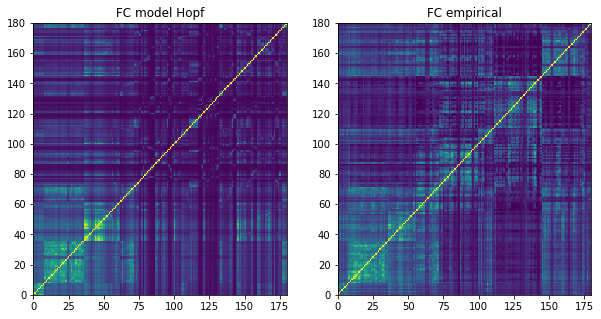

In [10]:
f, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].pcolormesh(hm.corr[network_order,:][:,network_order], vmin = 0.0, vmax = 1.0)
ax[0].set_title('FC model Hopf')
ax[1].pcolormesh(fc_hcp[network_order,:][:,network_order], vmin = 0.0, vmax = 1.0)
ax[1].set_title('FC empirical')